In [8]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set environment variable to suppress tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPU(s)")

# Load JSON dataset
json_path = '/kaggle/input/combined-landscape-captions/combined_landscape_captions.json'
with open(json_path, 'r') as f:
    data = json.load(f)
print(f"Total samples: {len(data)}")


Using 2 GPU(s)
Total samples: 14319


In [9]:
# Dataset class
class LandscapeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.image_paths = list(data.keys())
        self.captions = list(data.values())
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)
        return image, caption

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Initialize dataset and dataloaders
dataset = LandscapeDataset(data, transform=transform)
dataset = [(img, cap) for img, cap in dataset if img is not None]
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 16 * num_gpus
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# CLIP Model for Guidance
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("Done with all of the loading...")


Done with all of the loading...


In [23]:
class BigGANGenerator(nn.Module):
    def __init__(self, noise_dim, text_dim, base_dim=64):
        super(BigGANGenerator, self).__init__()
        self.fc = nn.Linear(noise_dim + text_dim, base_dim * 16 * 4 * 4)
        self.res_blocks = nn.Sequential(
            nn.ConvTranspose2d(base_dim * 16, base_dim * 8, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(base_dim * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 8, base_dim * 4, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(base_dim * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 4, base_dim * 2, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(base_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 2, base_dim, 4, 2, 1),  # 64x64
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim, 3, 4, 2, 1),  # 128x128
            nn.Tanh(),
        )

    def forward(self, noise, text_embedding):
        x = torch.cat([noise, text_embedding], dim=1)
        x = self.fc(x).view(-1, 64 * 16, 4, 4)
        return self.res_blocks(x)


class BigGANDiscriminator(nn.Module):
    def __init__(self, text_dim, base_dim=64, image_size=128):
        super(BigGANDiscriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, base_dim * 2, 4, 2, 1),  # Down to 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 2, base_dim * 4, 4, 2, 1),  # Down to 32x32
            nn.BatchNorm2d(base_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 4, base_dim * 8, 4, 2, 1),  # Down to 16x16
            nn.BatchNorm2d(base_dim * 8),
            nn.LeakyReLU(0.2),
        )

        # Dynamically calculate flattened size
        with torch.no_grad():
            sample_img = torch.randn(1, 3, image_size, image_size)
            conv_out = self.conv_blocks(sample_img)
            self.flattened_size = conv_out.numel()

        self.fc = nn.Linear(self.flattened_size + text_dim, 1)

    def forward(self, img, text_embedding):
        x_img = self.conv_blocks(img)  # Output shape: (batch_size, base_dim * 8, 16, 16)
        x_img = x_img.view(img.size(0), -1)  # Flatten to (batch_size, flattened_size)

        x = torch.cat([x_img, text_embedding], dim=1)  # Concatenate image features and text embeddings
        return self.fc(x)  # Output: (batch_size, 1)

# Initialize models
noise_dim = 128
text_dim = 512  # CLIP embedding size
generator = nn.DataParallel(BigGANGenerator(noise_dim, text_dim).to(device))
discriminator = nn.DataParallel(BigGANDiscriminator(text_dim).to(device))

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))



In [24]:
# Training loop
epochs = 20
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        clip_inputs = clip_processor(text=captions, images=None, return_tensors="pt", padding=True).to(device)
        text_embeddings = clip_model.get_text_features(**clip_inputs)

        # Generate fake images
        noise = torch.randn(images.size(0), noise_dim).to(device)
        fake_images = generator(noise, text_embeddings)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        d_loss_real = nn.BCEWithLogitsLoss()(discriminator(images, text_embeddings), real_labels)
        d_loss_fake = nn.BCEWithLogitsLoss()(discriminator(fake_images.detach(), text_embeddings), fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = nn.BCEWithLogitsLoss()(discriminator(fake_images, text_embeddings), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 1/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 1/20, D Loss: 0.8662, G Loss: 80.9752


Epoch 2/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 2/20, D Loss: 4.0382, G Loss: 19.0147


Epoch 3/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 3/20, D Loss: 0.2374, G Loss: 22.8688


Epoch 4/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 4/20, D Loss: 0.6666, G Loss: 11.7816


Epoch 5/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 5/20, D Loss: 0.3624, G Loss: 16.2859


Epoch 6/20: 100%|██████████| 358/358 [01:40<00:00,  3.56it/s]


Epoch 6/20, D Loss: 1.2784, G Loss: 9.8433


Epoch 7/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 7/20, D Loss: 0.3550, G Loss: 13.5408


Epoch 8/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 8/20, D Loss: 0.6033, G Loss: 14.4227


Epoch 9/20: 100%|██████████| 358/358 [01:40<00:00,  3.56it/s]


Epoch 9/20, D Loss: 0.1494, G Loss: 29.2331


Epoch 10/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 10/20, D Loss: 0.1166, G Loss: 11.1930


Epoch 11/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 11/20, D Loss: 1.6294, G Loss: 27.2469


Epoch 12/20: 100%|██████████| 358/358 [01:40<00:00,  3.56it/s]


Epoch 12/20, D Loss: 5.9276, G Loss: 12.7986


Epoch 13/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 13/20, D Loss: 0.7370, G Loss: 8.1075


Epoch 14/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 14/20, D Loss: 3.1701, G Loss: 20.1659


Epoch 15/20: 100%|██████████| 358/358 [01:40<00:00,  3.56it/s]


Epoch 15/20, D Loss: 0.5088, G Loss: 11.6050


Epoch 16/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 16/20, D Loss: 2.0919, G Loss: 30.3683


Epoch 17/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 17/20, D Loss: 0.0530, G Loss: 6.9698


Epoch 18/20: 100%|██████████| 358/358 [01:40<00:00,  3.56it/s]


Epoch 18/20, D Loss: 0.2002, G Loss: 11.3960


Epoch 19/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]


Epoch 19/20, D Loss: 0.1443, G Loss: 9.4127


Epoch 20/20: 100%|██████████| 358/358 [01:40<00:00,  3.57it/s]

Epoch 20/20, D Loss: 2.1741, G Loss: 18.2963


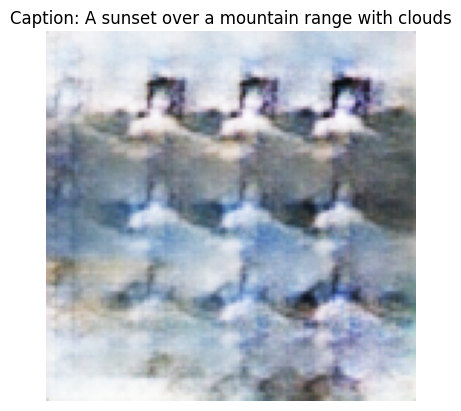

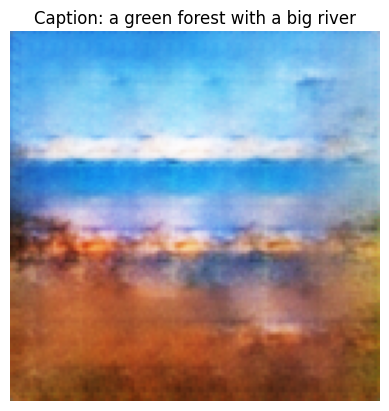

In [36]:
# Generate Images
def generate_images(generator, clip_model, clip_processor, text_list, device, noise_dim=128):
    generator.eval()
    with torch.no_grad():
        for text in text_list:
            clip_inputs = clip_processor(text=text, return_tensors="pt", padding=True).to(device)
            text_embedding = clip_model.get_text_features(**clip_inputs)
            noise = torch.randn(1, noise_dim).to(device)
            fake_image = generator(noise, text_embedding)
            fake_image = (fake_image.squeeze(0) * 0.5) + 0.5
            plt.imshow(fake_image.cpu().permute(1, 2, 0))
            plt.title(f"Caption: {text}")
            plt.axis('off')
            plt.show()

sample_captions = [
    "A sunset over a mountain range with clouds",
    "a green forest with a big river"
]
generate_images(generator, clip_model, clip_processor, sample_captions, device)


In [34]:
import os
# Ensure the directory for saving models exists

os.makedirs("/kaggle/working/model", exist_ok=True)
# Save model checkpoints
torch.save(generator.state_dict(), os.path.join("/kaggle/working/model", f"generator.pth"))
torch.save(discriminator.state_dict(), os.path.join("/kaggle/working/model", f"discriminator.pth"))


In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set environment variable to suppress tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPU(s)")

# ----------------------------
# DATA LOADING AND PREPROCESSING
# ----------------------------

def load_data(json_path, transform):
    """Load and preprocess the dataset."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    dataset = [(Image.open(img_path).convert('RGB'), caption) for img_path, caption in data.items() if os.path.exists(img_path)]
    return LandscapeDataset(dataset, transform)

class LandscapeDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, caption = self.data[idx]
        image = self.transform(image)
        return image, caption

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# ----------------------------
# MODEL ARCHITECTURE
# ----------------------------

class BigGANGenerator(nn.Module):
    def __init__(self, noise_dim, text_dim, base_dim=64):
        super(BigGANGenerator, self).__init__()
        self.fc = nn.Linear(noise_dim + text_dim, base_dim * 16 * 4 * 4)
        self.res_blocks = nn.Sequential(
            nn.ConvTranspose2d(base_dim * 16, base_dim * 8, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(base_dim * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 8, base_dim * 4, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(base_dim * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 4, base_dim * 2, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(base_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim * 2, base_dim, 4, 2, 1),  # 64x64
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(base_dim, 3, 4, 2, 1),  # 128x128
            nn.Tanh(),
        )

    def forward(self, noise, text_embedding):
        x = torch.cat([noise, text_embedding], dim=1)
        x = self.fc(x).view(-1, 64 * 16, 4, 4)
        return self.res_blocks(x)

class BigGANDiscriminator(nn.Module):
    def __init__(self, text_dim, base_dim=64, image_size=128):
        super(BigGANDiscriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, base_dim * 2, 4, 2, 1),  # Down to 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 2, base_dim * 4, 4, 2, 1),  # Down to 32x32
            nn.BatchNorm2d(base_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 4, base_dim * 8, 4, 2, 1),  # Down to 16x16
            nn.BatchNorm2d(base_dim * 8),
            nn.LeakyReLU(0.2),
        )
        with torch.no_grad():
            sample_img = torch.randn(1, 3, image_size, image_size)
            conv_out = self.conv_blocks(sample_img)
            self.flattened_size = conv_out.numel()

        self.fc = nn.Linear(self.flattened_size + text_dim, 1)

    def forward(self, img, text_embedding):
        x_img = self.conv_blocks(img)
        x_img = x_img.view(img.size(0), -1)
        x = torch.cat([x_img, text_embedding], dim=1)
        return self.fc(x)

# ----------------------------
# MODEL TRAINING
# ----------------------------

def train_model(generator, discriminator, clip_model, clip_processor, train_loader, epochs, noise_dim):
    optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))

    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            clip_inputs = clip_processor(text=captions, images=None, return_tensors="pt", padding=True).to(device)
            text_embeddings = clip_model.get_text_features(**clip_inputs)

            # Generate fake images
            noise = torch.randn(images.size(0), noise_dim).to(device)
            fake_images = generator(noise, text_embeddings)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(images.size(0), 1).to(device)
            fake_labels = torch.zeros(images.size(0), 1).to(device)
            d_loss_real = nn.BCEWithLogitsLoss()(discriminator(images, text_embeddings), real_labels)
            d_loss_fake = nn.BCEWithLogitsLoss()(discriminator(fake_images.detach(), text_embeddings), fake_labels)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward(retain_graph=True)
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = nn.BCEWithLogitsLoss()(discriminator(fake_images, text_embeddings), real_labels)
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        

# ----------------------------
# MODEL EVALUATION
# ----------------------------

def generate_images(generator, clip_model, clip_processor, text_list, device, noise_dim):
    generator.eval()
    with torch.no_grad():
        for text in text_list:
            clip_inputs = clip_processor(text=text, return_tensors="pt", padding=True).to(device)
            text_embedding = clip_model.get_text_features(**clip_inputs)
            noise = torch.randn(1, noise_dim).to(device)
            fake_image = generator(noise, text_embedding)
            fake_image = (fake_image.squeeze(0) * 0.5) + 0.5
            plt.imshow(fake_image.cpu().permute(1, 2, 0))
            plt.title(f"Caption: {text}")
            plt.axis('off')
            plt.show()

# ----------------------------
# MAIN SCRIPT
# ----------------------------

# Load dataset
json_path = '/kaggle/input/combined-landscape-captions/combined_landscape_captions.json'
dataset = load_data(json_path, transform)

Using 2 GPU(s)


In [2]:
# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Initialize models
noise_dim = 128
text_dim = 512
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
generator = nn.DataParallel(BigGANGenerator(noise_dim, text_dim).to(device))
discriminator = nn.DataParallel(BigGANDiscriminator(text_dim).to(device))

# Train the model
train_model(generator, discriminator, clip_model, clip_processor, train_loader, epochs=20, noise_dim=noise_dim)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Epoch 1/20:   0%|          | 0/716 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1/20: 100%|██████████| 716/716 [01:51<00:00,  6.34it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/20: 100%|██████████| 716/716 [01:51<00:00,  6.42it/s]


Epoch 1/20, D Loss: 0.0591, G Loss: 12.7915


Epoch 2/20: 100%|██████████| 716/716 [01:53<00:00,  6.33it/s]


Epoch 2/20, D Loss: 4.4412, G Loss: 13.2211


Epoch 3/20: 100%|██████████| 716/716 [01:54<00:00,  6.23it/s]


Epoch 3/20, D Loss: 2.7157, G Loss: 10.2733


Epoch 4/20: 100%|██████████| 716/716 [01:55<00:00,  6.19it/s]


Epoch 4/20, D Loss: 2.6403, G Loss: 9.6735


Epoch 5/20: 100%|██████████| 716/716 [01:56<00:00,  6.17it/s]


Epoch 5/20, D Loss: 1.0412, G Loss: 6.6749


Epoch 6/20: 100%|██████████| 716/716 [01:56<00:00,  6.16it/s]


Epoch 6/20, D Loss: 3.6292, G Loss: 0.6920


Epoch 7/20: 100%|██████████| 716/716 [01:55<00:00,  6.17it/s]


Epoch 7/20, D Loss: 0.5138, G Loss: 7.0706


Epoch 8/20: 100%|██████████| 716/716 [01:56<00:00,  6.17it/s]


Epoch 8/20, D Loss: 2.0323, G Loss: 12.8183


Epoch 9/20: 100%|██████████| 716/716 [01:56<00:00,  6.16it/s]


Epoch 9/20, D Loss: 1.1385, G Loss: 12.8587


Epoch 10/20: 100%|██████████| 716/716 [01:56<00:00,  6.14it/s]


Epoch 10/20, D Loss: 1.8563, G Loss: 6.6722


Epoch 11/20: 100%|██████████| 716/716 [01:56<00:00,  6.16it/s]


Epoch 11/20, D Loss: 1.1992, G Loss: 3.1415


Epoch 12/20: 100%|██████████| 716/716 [01:55<00:00,  6.18it/s]


Epoch 12/20, D Loss: 1.3993, G Loss: 1.3823


Epoch 13/20: 100%|██████████| 716/716 [01:55<00:00,  6.20it/s]


Epoch 13/20, D Loss: 3.2994, G Loss: 1.5923


Epoch 14/20: 100%|██████████| 716/716 [01:55<00:00,  6.19it/s]


Epoch 14/20, D Loss: 0.6181, G Loss: 3.5711


Epoch 15/20: 100%|██████████| 716/716 [01:55<00:00,  6.19it/s]


Epoch 15/20, D Loss: 0.8555, G Loss: 3.8163


Epoch 16/20: 100%|██████████| 716/716 [01:55<00:00,  6.18it/s]


Epoch 16/20, D Loss: 1.2976, G Loss: 4.4485


Epoch 17/20: 100%|██████████| 716/716 [01:55<00:00,  6.18it/s]


Epoch 17/20, D Loss: 1.1467, G Loss: 4.5836


Epoch 18/20: 100%|██████████| 716/716 [01:55<00:00,  6.18it/s]


Epoch 18/20, D Loss: 1.6637, G Loss: 1.4808


Epoch 19/20: 100%|██████████| 716/716 [01:55<00:00,  6.19it/s]


Epoch 19/20, D Loss: 1.8840, G Loss: 6.2086


Epoch 20/20: 100%|██████████| 716/716 [01:56<00:00,  6.15it/s]

Epoch 20/20, D Loss: 0.7858, G Loss: 2.8173


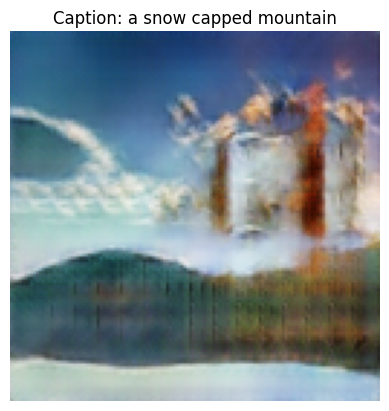

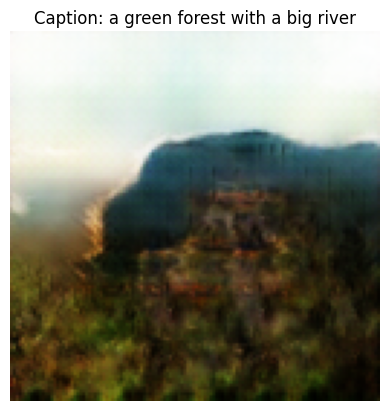

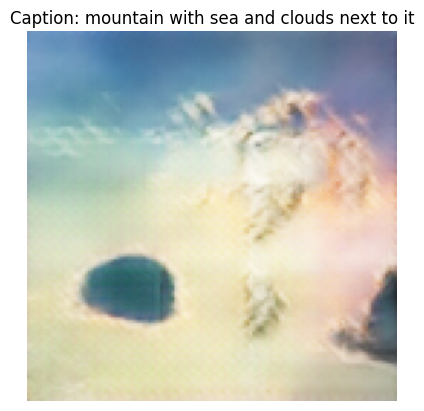

In [9]:

# Generate images
sample_captions = ["a snow capped mountain", "a green forest with a big river","mountain with sea and clouds next to it"]
generate_images(generator, clip_model, clip_processor, sample_captions, device, noise_dim=noise_dim)


In [26]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch

# ----------------------------
# Feature Extraction for FID
# ----------------------------
def get_inception_features(images, device):
    """Extract features from images using InceptionV3."""
    model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
    upsample = T.Resize((299, 299))  # Resize to InceptionV3 input size

    features = []
    with torch.no_grad():
        for img in images:
            img = upsample(img.unsqueeze(0))  # Reshape and resize
            feature = model(img.to(device))  # Extract features
            features.append(feature.cpu().numpy().squeeze())
    return np.array(features)

# ----------------------------
# FID Calculation
# ----------------------------
def calculate_fid_manual(real_images, fake_images, device):
    """Manually calculate FID score."""
    # Extract features
    real_features = get_inception_features(real_images, device)
    fake_features = get_inception_features(fake_images, device)

    # Calculate statistics
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)  # sqrt of product of covariances
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Handle numerical instabilities
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# ----------------------------
# Inception Score Calculation
# ----------------------------
def calculate_inception_score(fake_images, splits=10):
    """Calculate Inception Score for generated images."""
    model = inception_v3(pretrained=True, transform_input=False).eval().to(fake_images.device)
    upsample = T.Resize((299, 299))  # Resize to InceptionV3 input size

    with torch.no_grad():
        preds = []
        for img in fake_images:
            img = upsample(img.unsqueeze(0))  # Reshape and resize
            logits = model(img)
            p = F.softmax(logits, dim=1)  # Get probabilities
            preds.append(p)
        preds = torch.cat(preds, dim=0)

    # Compute IS
    split_scores = []
    batch_size = len(preds) // splits
    for k in range(splits):
        part = preds[k * batch_size:(k + 1) * batch_size, :]
        p_y = torch.mean(part, dim=0)  # Marginal probability
        scores = torch.sum(part * (torch.log(part + 1e-6) - torch.log(p_y + 1e-6)), dim=1)
        split_scores.append(torch.exp(torch.mean(scores)))

    score = torch.mean(torch.tensor(split_scores)).item()
    std = torch.std(torch.tensor(split_scores)).item()
    return score, std

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(generator, val_loader, clip_model, clip_processor, device, noise_dim):
    """
    Evaluate the model by calculating FID and Inception Score.
    Args:
        generator: Trained generator model.
        val_loader: DataLoader for validation dataset.
        clip_model: CLIP model.
        clip_processor: CLIP processor for text encoding.
        device: Torch device (CPU or GPU).
        noise_dim: Dimensionality of the noise vector.
    """
    generator.eval()

    # Select 10 real images and their corresponding captions
    real_images, captions = [], []
    for i in range(10):
        img, caption = val_loader.dataset[i]  # Fetch image and caption
        real_images.append(img)
        captions.append(caption)

    real_images = torch.stack(real_images).to(device)  # Stack real images

    # Generate fake images corresponding to the captions
    clip_inputs = clip_processor(text=captions, images=None, return_tensors="pt", padding=True).to(device)
    text_embeddings = clip_model.get_text_features(**clip_inputs)
    noise = torch.randn(len(captions), noise_dim).to(device)
    fake_images = generator(noise, text_embeddings)
    fake_images = torch.clamp((fake_images + 1) / 2, 0, 1)  # Rescale to [0, 1]

    # Calculate FID
    fid = calculate_fid_manual(real_images, fake_images, device)
    print(f"FID Score (Manual): {fid:.4f}")

    # Calculate IS
    is_score, is_std = calculate_inception_score(fake_images)
    print(f"Inception Score: {is_score:.4f} ± {is_std:.4f}")

# ----------------------------
# Evaluation Function Call
# ----------------------------
# Evaluate the model after training
evaluate_model(generator, val_loader, clip_model, clip_processor, device, noise_dim=noise_dim)


FID Score (Manual): 1204.7296
Inception Score: 1.0000 ± 0.0000


In [15]:
!pip show torch-fidelity



Name: torch-fidelity
Version: 0.3.0
Summary: High-fidelity performance metrics for generative models in PyTorch
Home-page: https://www.github.com/toshas/torch-fidelity
Author: Anton Obukhov
Author-email: 
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, Pillow, scipy, torch, torchvision, tqdm
Required-by: 
